In [24]:
# === 0) Setup & Load ===
from pathlib import Path
import pandas as pd
import numpy as np

RES_DIR = Path("../results"); RES_DIR.mkdir(exist_ok=True, parents=True)
FIG_DIR = RES_DIR / "figures"; FIG_DIR.mkdir(exist_ok=True, parents=True)
MODEL_DIR = RES_DIR / "models"; MODEL_DIR.mkdir(exist_ok=True, parents=True)

df = pd.read_parquet("../data_work/loans_fe.parquet")  # or the latest engineered file
TARGET = "target"
TIME_COL = "issue_q_start"


In [25]:
# === 1) Time-based Split (train: <= 2017-12-31, test: >= 2018-01-01) ===
split_date = pd.Timestamp("2017-12-31")
train_df = df[df[TIME_COL] <= split_date].copy()
test_df  = df[df[TIME_COL] >  split_date].copy()

X_train = train_df.drop(columns=[TARGET, TIME_COL])
y_train = train_df[TARGET].astype(int)
X_test  = test_df.drop(columns=[TARGET, TIME_COL])
y_test  = test_df[TARGET].astype(int)

print(X_train.shape, X_test.shape, y_train.mean(), y_test.mean())


(1764843, 31) (494110, 31) 0.14756893389383646 0.01791706300216551


In [26]:
# === 2) Preprocessor: scale only continuous numeric features; passthrough booleans ===
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

# continuous numerics = numeric with >2 unique values
cont_cols = [c for c in X_train.columns if np.issubdtype(X_train[c].dtype, np.number) and X_train[c].nunique() > 2]
# booleans (True/False one-hots)
bool_cols = X_train.select_dtypes(include=["bool"]).columns.tolist()
# any leftover small-cardinality numeric dummies (0/1) if present
bin_num_cols = [c for c in X_train.columns if c not in cont_cols and c not in bool_cols]

pre = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), cont_cols),
        ("bool", "passthrough", bool_cols + bin_num_cols),
    ],
    remainder="drop",
)
print(f"Scaling {len(cont_cols)} continuous features; passing through {len(bool_cols)+len(bin_num_cols)} binary features.")

Scaling 15 continuous features; passing through 16 binary features.


In [27]:
cont_cols

['loan_amnt',
 'int_rate',
 'dti',
 'fico',
 'emp_length',
 'GDPC1',
 'UNRATE',
 'CPIAUCSL',
 'FEDFUNDS',
 'log_annual_inc',
 'UNRATE_delta_qoq',
 'FEDFUNDS_delta_qoq',
 'GDPC1_delta_qoq',
 'inflation_qoq',
 'real_rate_qoq']

In [28]:
bool_cols

['grade_b',
 'grade_c',
 'grade_d',
 'grade_e',
 'grade_f',
 'home_ownership_mortgage',
 'home_ownership_own',
 'home_ownership_rent',
 'purpose_credit_card',
 'purpose_debt_consolidation',
 'purpose_home_improvement',
 'purpose_major_purchase',
 'purpose_medical',
 'purpose_other',
 'purpose_small_business']

In [29]:
bin_num_cols

['term_m']

In [30]:
# === 3) Train class-balanced Logistic Regression 
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

logreg = Pipeline([
    ("pre", pre),
    ("clf", LogisticRegression(max_iter=1000, class_weight="balanced", n_jobs=-1, solver="lbfgs"))
])
logreg.fit(X_train, y_train)
proba_lr_train = logreg.predict_proba(X_train)[:,1]
proba_lr_test  = logreg.predict_proba(X_test)[:,1]
print(f"LogReg AUC — train: {roc_auc_score(y_train, proba_lr_train):.3f}  test: {roc_auc_score(y_test, proba_lr_test):.3f}")


LogReg AUC — train: 0.706  test: 0.742


In [ ]:
#  Tree model: XGBoost if available; else HistGradientBoostingClassifier
proba_xgb_train = proba_xgb_test = None
try:
    from xgboost import XGBClassifier
    pos = int((y_train==1).sum()); neg = int((y_train==0).sum())
    spw = max(1.0, neg / max(1, pos))
    xgb = Pipeline([
        ("pre", pre),
        ("clf", XGBClassifier(
            n_estimators=500, max_depth=4, learning_rate=0.07,
            subsample=0.9, colsample_bytree=0.9, min_child_weight=1.0,
            reg_lambda=1.0, objective="binary:logistic", eval_metric="auc",
            tree_method="hist", random_state=42, scale_pos_weight=spw
        ))
    ])
    xgb.fit(X_train, y_train)
    proba_xgb_train = xgb.predict_proba(X_train)[:,1]
    proba_xgb_test  = xgb.predict_proba(X_test)[:,1]
    print(f"XGB AUC — train: {roc_auc_score(y_train, proba_xgb_train):.3f}  test: {roc_auc_score(y_test, proba_xgb_test):.3f}")
except Exception as e:
    from sklearn.ensemble import HistGradientBoostingClassifier
    hgb = Pipeline([
        ("pre", pre),
        ("clf", HistGradientBoostingClassifier(max_depth=4, learning_rate=0.07, random_state=42))
    ])
    hgb.fit(X_train, y_train)
    # decision_function-like output → use predict_proba via calibration trick? Not needed; use decision_function_
    # HGB exposes predict_proba for binary in recent sklearn; fall back to decision_function if needed:
    try:
        proba_xgb_train = hgb.predict_proba(X_train)[:,1]
        proba_xgb_test  = hgb.predict_proba(X_test)[:,1]
    except Exception:
        from sklearn.utils._response import _sigmoid
        proba_xgb_train = _sigmoid(hgb.decision_function(X_train))
        proba_xgb_test  = _sigmoid(hgb.decision_function(X_test))
    print(f"HGB AUC — train: {roc_auc_score(y_train, proba_xgb_train):.3f}  test: {roc_auc_score(y_test, proba_xgb_test):.3f}")
    xgb = hgb  # alias for downstream naming


XGB AUC — train: 0.718  test: 0.679


In [32]:
# === 4) Threshold tuning (maximize F1; change goal to “recall” if needed)
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score

def threshold_search(y_true, y_proba, grid=np.linspace(0.05, 0.5, 20), goal="f1"):
    best_t, best = 0.5, -1
    recs = []
    for t in grid:
        yhat = (y_proba >= t).astype(int)
        p = precision_score(y_true, yhat, zero_division=0)
        r = recall_score(y_true, yhat, zero_division=0)
        f = f1_score(y_true, yhat, zero_division=0)
        score = {"f1": f, "recall": r, "precision": p}[goal]
        recs.append((t, p, r, f))
        if score > best:
            best, best_t = score, t
    return best_t, np.array(recs)

best_t_lr, recs_lr = threshold_search(y_test, proba_lr_test, goal="f1")
print(f"Best threshold (LogReg) for F1: {best_t_lr:.3f}")

best_t_xgb = None
if proba_xgb_test is not None:
    best_t_xgb, recs_xgb = threshold_search(y_test, proba_xgb_test, goal="f1")
    print(f"Best threshold (Tree) for F1: {best_t_xgb:.3f}")


Best threshold (LogReg) for F1: 0.405
Best threshold (Tree) for F1: 0.500


In [33]:
# === 5) Full evaluation (AUC, F1, Precision, Recall, Accuracy) + figures ===

import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_auc_score, accuracy_score, f1_score, precision_score, recall_score,
    RocCurveDisplay, PrecisionRecallDisplay, average_precision_score,
    confusion_matrix, ConfusionMatrixDisplay
)
import csv

metrics = []


In [34]:
# Logistic
yhat_lr = (proba_lr_test >= best_t_lr).astype(int)
metrics.append({
    "model": "logistic_balanced",
    "auc": roc_auc_score(y_test, proba_lr_test),
    "f1": f1_score(y_test, yhat_lr, zero_division=0),
    "accuracy": accuracy_score(y_test, yhat_lr),
    "precision": precision_score(y_test, yhat_lr, zero_division=0),
    "recall": recall_score(y_test, yhat_lr, zero_division=0),
    "ap": average_precision_score(y_test, proba_lr_test),
    "threshold": best_t_lr
})

In [35]:
metrics

[{'model': 'logistic_balanced',
  'auc': 0.7416747059087543,
  'f1': 0.10505310984220544,
  'accuracy': 0.9410009916820141,
  'precision': 0.07213018000927449,
  'recall': 0.19326781881847963,
  'ap': 0.050930068928154174,
  'threshold': np.float64(0.4052631578947368)}]

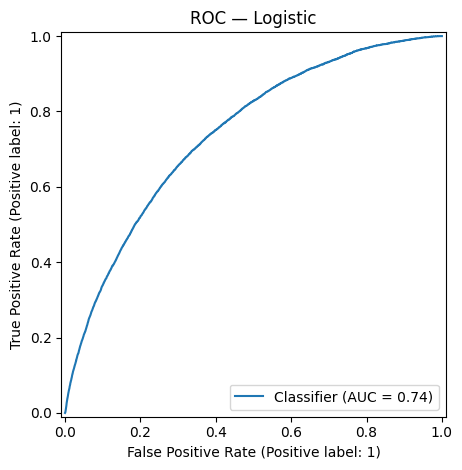

In [36]:
RocCurveDisplay.from_predictions(y_test, proba_lr_test)
plt.title("ROC — Logistic")
plt.tight_layout()
plt.savefig(FIG_DIR/"roc_logistic.png", dpi=300)
plt.show()

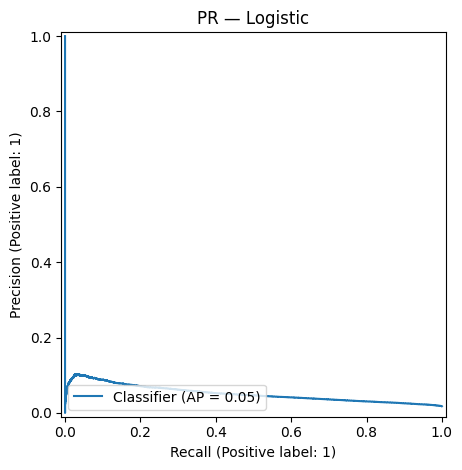

In [37]:
PrecisionRecallDisplay.from_predictions(y_test, proba_lr_test)
plt.title("PR — Logistic")
plt.tight_layout()
plt.savefig(FIG_DIR/"pr_logistic.png", dpi=300)
plt.show()


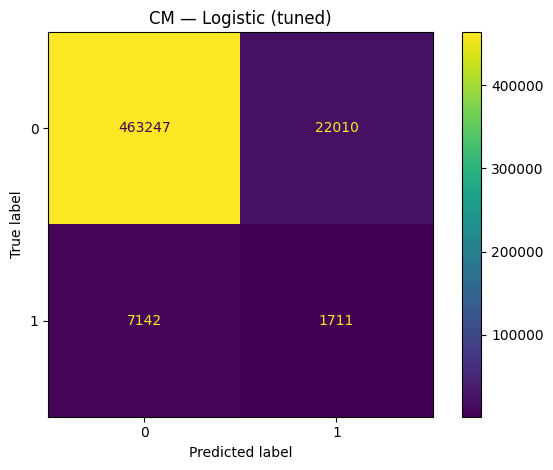

In [38]:
ConfusionMatrixDisplay(confusion_matrix(y_test, yhat_lr)).plot(values_format="d")
plt.title("CM — Logistic (tuned)")
plt.tight_layout()
plt.savefig(FIG_DIR/"cm_logistic.png", dpi=300)
plt.show()


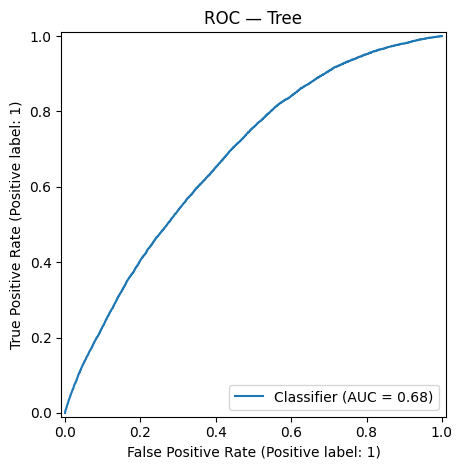

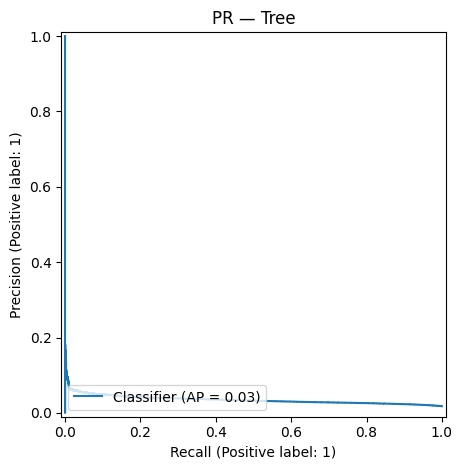

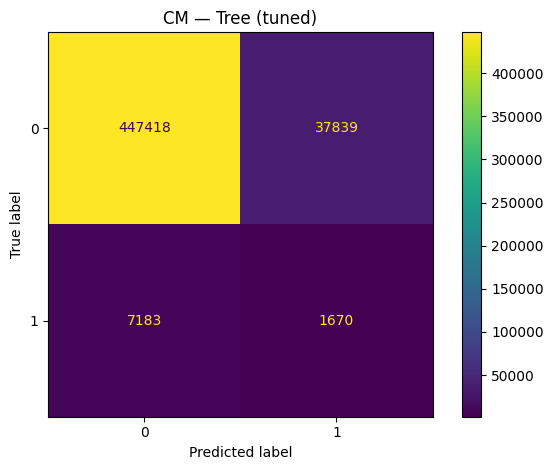

In [39]:
# Tree model (XGB or HGB)
if proba_xgb_test is not None and best_t_xgb is not None:
    yhat_xgb = (proba_xgb_test >= best_t_xgb).astype(int)
    metrics.append({
        "model": "xgb_or_hgb_balanced",
        "auc": roc_auc_score(y_test, proba_xgb_test),
        "f1": f1_score(y_test, yhat_xgb, zero_division=0),
        "accuracy": accuracy_score(y_test, yhat_xgb),
        "precision": precision_score(y_test, yhat_xgb, zero_division=0),
        "recall": recall_score(y_test, yhat_xgb, zero_division=0),
        "ap": average_precision_score(y_test, proba_xgb_test),
        "threshold": best_t_xgb
    })
    RocCurveDisplay.from_predictions(y_test, proba_xgb_test); plt.title("ROC — Tree"); plt.tight_layout(); plt.savefig(FIG_DIR/"roc_tree.png", dpi=300); plt.show()
    PrecisionRecallDisplay.from_predictions(y_test, proba_xgb_test); plt.title("PR — Tree"); plt.tight_layout(); plt.savefig(FIG_DIR/"pr_tree.png", dpi=300); plt.show()
    ConfusionMatrixDisplay(confusion_matrix(y_test, yhat_xgb)).plot(values_format="d"); plt.title("CM — Tree (tuned)"); plt.tight_layout(); plt.savefig(FIG_DIR/"cm_tree.png", dpi=300); plt.show()

In [42]:
metrics

[{'model': 'logistic_balanced',
  'auc': 0.7416747059087543,
  'f1': 0.10505310984220544,
  'accuracy': 0.9410009916820141,
  'precision': 0.07213018000927449,
  'recall': 0.19326781881847963,
  'ap': 0.050930068928154174,
  'threshold': np.float64(0.4052631578947368)},
 {'model': 'xgb_or_hgb_balanced',
  'auc': 0.6793896667011681,
  'f1': 0.06906248707663042,
  'accuracy': 0.9088826374693894,
  'precision': 0.042268850135412185,
  'recall': 0.18863662035468204,
  'ap': 0.03499114042581632,
  'threshold': np.float64(0.5)}]

In [ ]:
# === 6) Save metrics===
metrics_path = RES_DIR / "model_metrics.csv"
write_header = not metrics_path.exists()
with metrics_path.open("a", newline="", encoding="utf-8") as f:
    writer = csv.DictWriter(f, fieldnames=["model","auc","f1","accuracy","precision","recall","ap","threshold"])
    if write_header: writer.writeheader()
    for m in metrics: writer.writerow(m)
print("✅ Saved metrics →", metrics_path)
print("📈 Saved figures →", FIG_DIR)

✅ Saved metrics → ../results/model_metrics.csv
📈 Saved figures → ../results/figures


In [44]:
# === 7) Persist models (for stress testing phase)===
import joblib
joblib.dump(logreg, MODEL_DIR / "logistic_balanced.joblib")
if 'xgb' in locals() and xgb is not None:
    joblib.dump(xgb, MODEL_DIR / "tree_balanced.joblib")
print("Models saved to:", MODEL_DIR)


Models saved to: ../results/models
